In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

In [45]:
import seaborn as sns
sns.set_style('darkgrid')

In [2]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

In [3]:
df = pd.read_csv('GSPC_2015_2020.csv')

In [4]:
spx = df.set_index('Date').pct_change()['Adj Close'].fillna(0)
spx.describe(), spx.isnull().sum()

(count    1259.000000
 mean        0.000538
 std         0.012115
 min        -0.119841
 25%        -0.002932
 50%         0.000648
 75%         0.005094
 max         0.093828
 Name: Adj Close, dtype: float64,
 0)

In [6]:
from tensorflow.keras.preprocessing.sequence import TimeseriesGenerator
train_gen_df = (spx.loc[:'2019-08-20'] - spx.loc[:'2019-08-20'].mean()) / spx.loc[:'2019-08-20'].std()
test_gen_df = (spx.loc['2019-08-20':] - spx.loc[:'2019-08-20'].mean()) / spx.loc[:'2019-08-20'].std()
train_data_gen = TimeseriesGenerator(train_gen_df.values, train_gen_df, length=30)
test_data_gen = TimeseriesGenerator(test_gen_df.values, test_gen_df, length=30)
train_data_gen[0][0].shape

(128, 30)

In [7]:
# https://github.com/usernaamee/keras-wavenet/blob/master/simple-generative-model.py

In [55]:
from tensorflow.keras.layers import Convolution1D, Convolution2D, Flatten, Dense, \
    Input, Lambda, Activation, BatchNormalization
from tensorflow import keras
import tensorflow

def WaveNetBlock(filters, kernel_size, dilation_rate, activation=None):
    def f(input_):
        residual = input_
        tanh_out = Convolution1D(filters, kernel_size,
                                       dilation_rate=dilation_rate,
                                       padding='same',
                                       activation='tanh')(input_)
        sigmoid_out = Convolution1D(filters, kernel_size,
                                          dilation_rate=dilation_rate,
                                          padding='same',
                                          activation='relu')(input_)
        merged = keras.layers.Multiply()([tanh_out, sigmoid_out])
        skip_out = Convolution1D(1, 1, activation=activation, padding='same')(merged)
        out = keras.layers.Add()([skip_out, residual])
        return out, skip_out
#         return skip_out
    return f

In [46]:
def evaluate_model(model, hist):
    total_mae = mean_absolute_error(train_gen_df[30:], np.zeros_like(train_gen_df[30:]))
    model_mae = mean_absolute_error(np.squeeze(model.predict(train_data_gen)), train_gen_df[30:]) 
    print('train', model_mae, total_mae, model_mae/total_mae)
    total_mae = mean_absolute_error(test_gen_df[30:], np.zeros_like(test_gen_df[30:]))
    model_mae = mean_absolute_error(np.squeeze(model.predict(test_data_gen)), test_gen_df[30:]) 
    print('test', model_mae, total_mae, model_mae/total_mae)
    plt.scatter(np.squeeze(model.predict(train_data_gen)), train_gen_df[30:])
    plt.title('training')
    plt.subplots()
    plt.scatter(np.squeeze(model.predict(test_data_gen)), test_gen_df[30:])
    plt.title('testing')
    pd.DataFrame(hist.history).plot()

Simple Dilated Covnet, filter=1, kernel=1

train 0.654186094462244 0.6542154487460116 0.9999551305555014
test 1.4865764156536923 1.4872528866796857 0.999545154000337


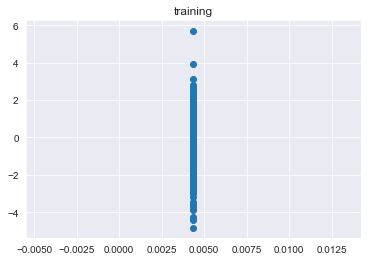

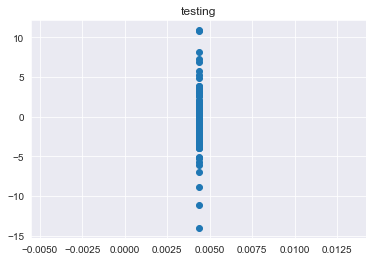

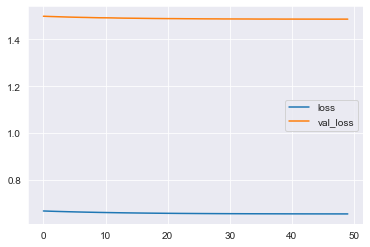

In [47]:
x = i = Input(shape=(30, 1))
x = BatchNormalization()(x)
x = Convolution1D(filters=1, kernel_size=1, dilation_rate=1, padding='same', activation='relu')(x)
x = Convolution1D(filters=1, kernel_size=1, dilation_rate=2, padding='same', activation='relu')(x)
x = Convolution1D(filters=1, kernel_size=1, dilation_rate=4, padding='same', activation='relu')(x)
x = Convolution1D(filters=1, kernel_size=1, dilation_rate=8, padding='same', activation='relu')(x)
x = Flatten()(x)

x = Dense(1, activation='linear', kernel_regularizer='l2')(x)


model = keras.Model(i, x)
model.compile(optimizer=tensorflow.keras.optimizers.Adam(1e-3), loss='mae')
hist = model.fit(train_data_gen, epochs=50, validation_data=test_data_gen, verbose=0)
evaluate_model(model, hist)
hist

Wavenet, filter=1, kernel=1

train 0.6660424693909024 0.6542154487460116 1.0180781738914308
test 1.471555771023409 1.4872528866796857 0.9894455638332492


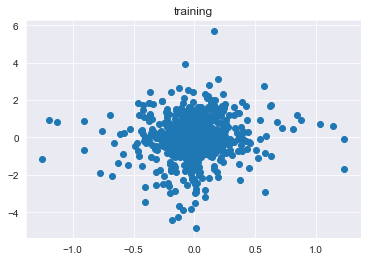

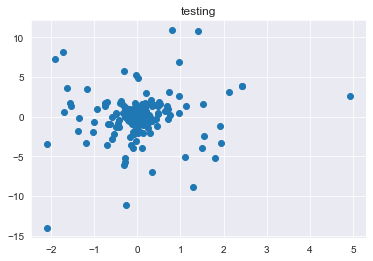

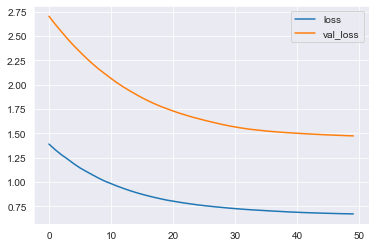

In [56]:
x = i = Input(shape=(30, 1))
x = BatchNormalization()(x)
x, _ = WaveNetBlock(filters=1, kernel_size=1, dilation_rate=1, activation='relu')(x)
x, _ = WaveNetBlock(filters=1, kernel_size=1, dilation_rate=2, activation='relu')(x)
x, _ = WaveNetBlock(filters=1, kernel_size=1, dilation_rate=4, activation='relu')(x)
x, _ = WaveNetBlock(filters=1, kernel_size=1, dilation_rate=8, activation='relu')(x)
x = Flatten()(x)

x = Dense(1, activation='linear', kernel_regularizer='l2')(x)


model = keras.Model(i, x)
model.compile(optimizer=tensorflow.keras.optimizers.Adam(1e-3), loss='mae')
hist = model.fit(train_data_gen, epochs=50, validation_data=test_data_gen, verbose=0)
evaluate_model(model, hist)
hist

In [ ]:
# x = WaveNetBlock(filters=4, kernel_size=8, dilation_rate=1, activation='relu')(x)
# x = WaveNetBlock(filters=8, kernel_size=4, dilation_rate=2, activation='relu')(x)
# x = WaveNetBlock(filters=16, kernel_size=2, dilation_rate=4, activation='relu')(x)
# x = WaveNetBlock(filters=32, kernel_size=1, dilation_rate=8, activation='relu')(x)

ConvNet, variable filters / kernel_size

train 0.3820634603570971 0.6542154487460116 0.5840025042047379
test 1.5542406635614043 1.4872528866796857 1.0450412821394954


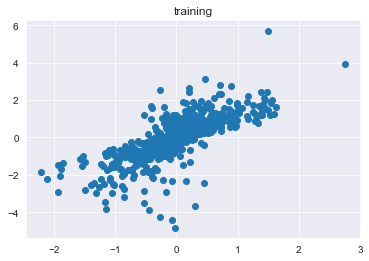

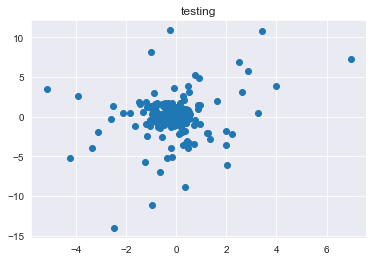

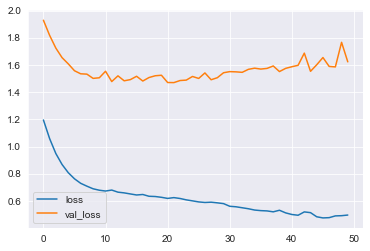

In [50]:
x = i = Input(shape=(30, 1))
x = BatchNormalization()(x)
x = Convolution1D(filters=4, kernel_size=8, dilation_rate=1, padding='same', activation='relu')(x)
x = Convolution1D(filters=8, kernel_size=4, dilation_rate=2, padding='same', activation='relu')(x)
x = Convolution1D(filters=16, kernel_size=2, dilation_rate=4, padding='same', activation='relu')(x)
x = Convolution1D(filters=32, kernel_size=1, dilation_rate=8, padding='same', activation='relu')(x)
x = Flatten()(x)
x = Dense(30, activation='relu', kernel_regularizer='l2')(x)
# x = Dense(30, activation='relu', kernel_regularizer='l2')(x)
x = Dense(1, activation='linear', kernel_regularizer='l2')(x)


model = keras.Model(i, x)
model.compile(optimizer=tensorflow.keras.optimizers.Adam(1e-3), loss='mae')
hist = model.fit(train_data_gen, epochs=50, validation_data=test_data_gen, verbose=0)
evaluate_model(model, hist)
hist

ConvNet, variable filters / kernel_size, final layer non-regularised

train 0.26336395734416435 0.6542154487460116 0.4025645646995583
test 1.6708298432570543 1.4872528866796857 1.1234335856541566


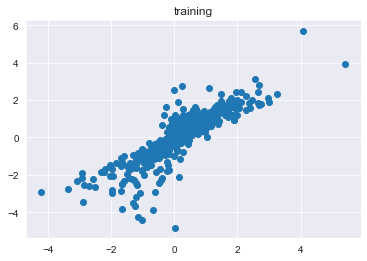

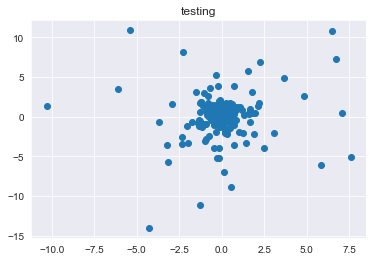

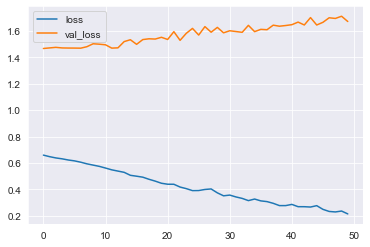

In [53]:
x = i = Input(shape=(30, 1))
x = BatchNormalization()(x)
x = Convolution1D(filters=4, kernel_size=8, dilation_rate=1, padding='same', activation='relu')(x)
x = Convolution1D(filters=8, kernel_size=4, dilation_rate=2, padding='same', activation='relu')(x)
x = Convolution1D(filters=16, kernel_size=2, dilation_rate=4, padding='same', activation='relu')(x)
x = Convolution1D(filters=32, kernel_size=1, dilation_rate=8, padding='same', activation='relu')(x)
x = Flatten()(x)
x = Dense(30, activation='relu')(x)
# x = Dense(30, activation='relu', kernel_regularizer='l2')(x)
x = Dense(1, activation='linear')(x)


model = keras.Model(i, x)
model.compile(optimizer=tensorflow.keras.optimizers.Adam(1e-3), loss='mae')
hist = model.fit(train_data_gen, epochs=50, validation_data=test_data_gen, verbose=0)
evaluate_model(model, hist)
hist

WaveNet, variable filter/kernel

train 0.5862625759942439 0.6542154487460116 0.8961307427361759
test 1.5491976020681728 1.4872528866796857 1.0416504253871577


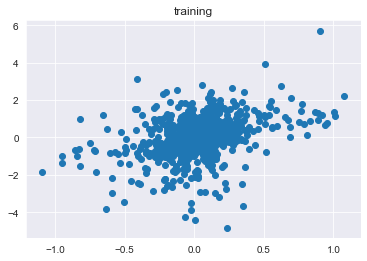

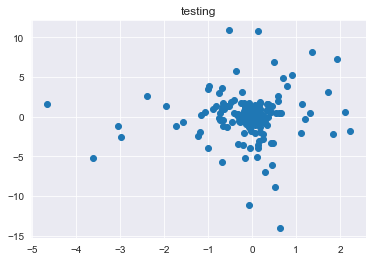

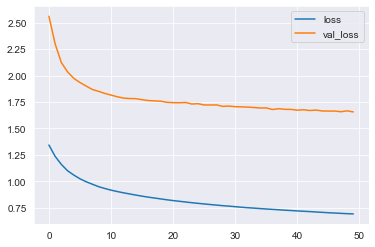

In [57]:
x = i = Input(shape=(30, 1))
x = BatchNormalization()(x)
x, _ = WaveNetBlock(filters=4, kernel_size=8, dilation_rate=1, activation='relu')(x)
x, _ = WaveNetBlock(filters=8, kernel_size=4, dilation_rate=2, activation='relu')(x)
x, _ = WaveNetBlock(filters=16, kernel_size=2, dilation_rate=4, activation='relu')(x)
x, _ = WaveNetBlock(filters=32, kernel_size=1, dilation_rate=8, activation='relu')(x)
x = Flatten()(x)
x = Dense(30, activation='relu', kernel_regularizer='l2')(x)
# x = Dense(30, activation='relu', kernel_regularizer='l2')(x)
x = Dense(1, activation='linear', kernel_regularizer='l2')(x)


model = keras.Model(i, x)
model.compile(optimizer=tensorflow.keras.optimizers.Adam(1e-3), loss='mae')
hist = model.fit(train_data_gen, epochs=50, validation_data=test_data_gen, verbose=0)
evaluate_model(model, hist)
hist

WaveNet, variable filter/kernel, non-regularised

train 0.5820870283909544 0.6542154487460116 0.8897482159840284
test 1.5381196678998539 1.4872528866796857 1.034201837277135


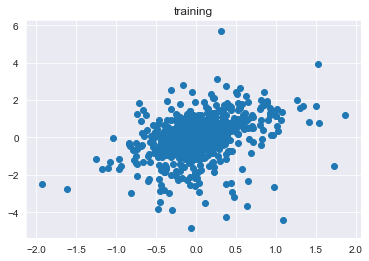

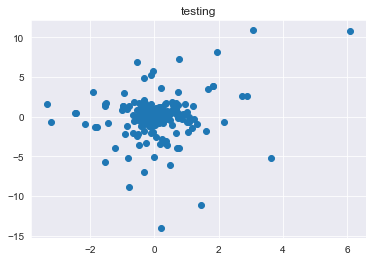

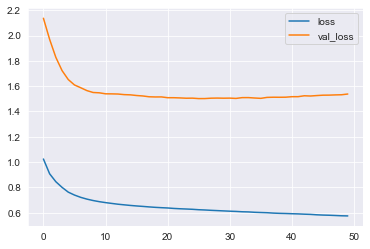

In [58]:
x = i = Input(shape=(30, 1))
x = BatchNormalization()(x)
x, _ = WaveNetBlock(filters=4, kernel_size=8, dilation_rate=1, activation='relu')(x)
x, _ = WaveNetBlock(filters=8, kernel_size=4, dilation_rate=2, activation='relu')(x)
x, _ = WaveNetBlock(filters=16, kernel_size=2, dilation_rate=4, activation='relu')(x)
x, _ = WaveNetBlock(filters=32, kernel_size=1, dilation_rate=8, activation='relu')(x)
x = Flatten()(x)
x = Dense(30, activation='relu')(x)
# x = Dense(30, activation='relu', kernel_regularizer='l2')(x)
x = Dense(1, activation='linear')(x)


model = keras.Model(i, x)
model.compile(optimizer=tensorflow.keras.optimizers.Adam(1e-3), loss='mae')
hist = model.fit(train_data_gen, epochs=50, validation_data=test_data_gen, verbose=0)
evaluate_model(model, hist)
hist

In [36]:
import tensorflow as tf
tf.config.experimental.list_logical_devices()

[LogicalDevice(name='/device:CPU:0', device_type='CPU'),
 LogicalDevice(name='/device:XLA_CPU:0', device_type='XLA_CPU'),
 LogicalDevice(name='/device:GPU:0', device_type='GPU'),
 LogicalDevice(name='/device:XLA_GPU:0', device_type='XLA_GPU')]